# Introduction
Describe the data and where you got the data. Describe the question being answered and the method(s) being used to answer the question.

# Import required libraries
Import necessary libraries such as pandas, matplotlib, seaborn, and scipy for running the code.

In [ ]:
import pandas as pd
import plotnine as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

%matplotlib inline

# Data pre-processing
Load and pre-process the dataset.

In [70]:
# https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

# Load the dataset
data = 'Data/RawData.csv'

# Read the dataset
data = pd.read_csv(data)
data.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [71]:
# Identify missing values
data.isnull().sum()
print(data.isnull().sum())

# Shape of the dataset
data.shape
print(data.shape)

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
(2111, 17)


In [72]:
# Transform all the categorical x variables into numerical variables

# Transform 'Gender' column to numerical values, Female 0 and Male 1
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
# Check the transformation
print(data['Gender'].head())

# Transform binary columns to numerical values (yes = 1, no = 0)
columns_to_transform = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
for column in columns_to_transform:
    data[column] = data[column].map({'yes': 1, 'no': 0})
# Check the transformation
print(data[columns_to_transform].head())


# Transform 'CAEC' column to numerical values
data['CAEC'] = data['CAEC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Check the transformation
print(data['CAEC'].head())
# Transform 'CALC' column to numerical values
data['CALC'] = data['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Check the transformation
print(data['CALC'].head())
# Transform 'MTRANS' column to numerical values
data['MTRANS'] = data['MTRANS'].map({'Public_Transportation': 1, 'Walking' : 2, 'Automobile': 3, 'Motorbike': 4, 'Bike': 5})
# Check the transformation
print(data['MTRANS'].head())



0    0
1    0
2    1
3    1
4    1
Name: Gender, dtype: int64
   family_history_with_overweight  FAVC  SMOKE  SCC
0                               1     0      0    0
1                               1     0      1    1
2                               1     0      0    0
3                               0     0      0    0
4                               0     0      0    0
0    1
1    1
2    1
3    1
4    1
Name: CAEC, dtype: int64
0    0
1    1
2    2
3    2
4    1
Name: CALC, dtype: int64
0    1
1    1
2    1
3    2
4    1
Name: MTRANS, dtype: int64


In [73]:
# Transform 'NObeyesdad' column to numerical values Overweight = 1, No_Overweight = 0
data['NObeyesdad'] = data['NObeyesdad'].map({'Insufficient_Weight': 0, 'Normal_Weight': 0, 'Overweight_Level_I': 1, 'Overweight_Level_II': 1, 'Obesity_Type_I': 1,  'Obesity_Type_II': 1, 'Obesity_Type_III': 1})
# Check the transformation
print(data['NObeyesdad'].head())

# Rename the column 'NObeyesdad' to 'Overweight'
data.rename(columns={'NObeyesdad': 'Overweight'}, inplace=True)

0    0
1    0
2    0
3    1
4    1
Name: NObeyesdad, dtype: int64


In [74]:
# Statistical description of the DataFrame
data.describe()
print(data.describe())

            Gender          Age       Height       Weight  \
count  2111.000000  2111.000000  2111.000000  2111.000000   
mean      0.505921    24.312600     1.701677    86.586058   
std       0.500083     6.345968     0.093305    26.191172   
min       0.000000    14.000000     1.450000    39.000000   
25%       0.000000    19.947192     1.630000    65.473343   
50%       1.000000    22.777890     1.700499    83.000000   
75%       1.000000    26.000000     1.768464   107.430682   
max       1.000000    61.000000     1.980000   173.000000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2111.000000  2111.000000  2111.000000  2111.000000   
mean                         0.817622     0.883941     2.419043     2.685628   
std                          0.386247     0.320371     0.533927     0.778039   
min                          0.000000     0.000000     1.000000     1.000000   
25%                          1.000000     1.000000

# Model setup
Setup one or more models.

In [75]:
# Setup train/test data

# Get the y values and drop from df
y= data.Overweight
# Drop the y column from the DataFrame
X= data.drop(columns='Overweight')

# Split to 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data in x_train and x_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
# Create and fit a model using our data
model = Pipeline([
    ('logistic', LogisticRegression(solver='liblinear'))
     ])     
model.fit(X_train,y_train)

Pipeline(steps=[('logistic', LogisticRegression(solver='liblinear'))])

In [77]:
# Mean Squared Error
def mse(model, x, y): 
    return np.mean((y-model.predict(x))**2)

print('R^2:', model.score(X_train, y_train), 'MSE:', mse(model, X_train, y_train))

R^2: 0.9842072015161086 MSE: 0.015792798483891344


# Hyperparameter tuning
Do some playing with the model hyperparameters (learning rate, optimizer, batch size, epochs, whatever makes sense)

In [53]:
# Define the base model
logistic = LogisticRegression(solver='liblinear')

# Define the hyperparameters you want to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse regularization strength (higher values = less regularization)
    'penalty': ['l1', 'l2']  # Type of regularization
}

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Use the best model found
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'C': 10, 'penalty': 'l1'}
Best accuracy: 0.9943197699956077


# Results


### Test the model without hyperparameter tuning

In [ ]:
# Predict ys using model and test data
y_pred = model.predict(X_test)

# Get model.score for both training and test data
print(f'Model score on training data: {model.score(X_train, y_train)}')
print(f'Model score on testing data: {model.score(X_test, y_test)}')

Model score on training data: 0.9842072015161086
Model score on testing data: 0.9810606060606061


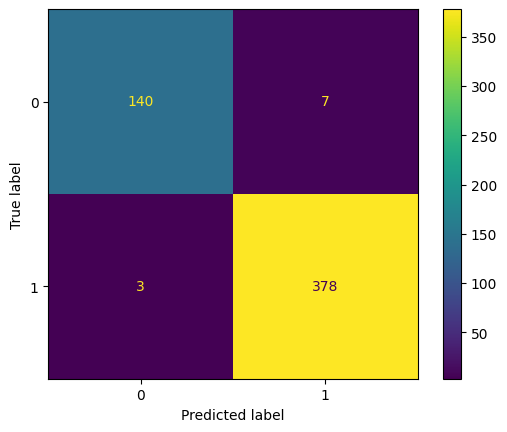

In [79]:
# Print the confusion matrix on the test data
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred), display_labels=model['logistic'].classes_).plot()

In [80]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       147
           1       0.98      0.99      0.99       381

    accuracy                           0.98       528
   macro avg       0.98      0.97      0.98       528
weighted avg       0.98      0.98      0.98       528



In [81]:
print(model['logistic'].coef_)

# odds = exp(coef_)
odds = np.exp(model['logistic'].coef_)

# Create a dataframe and sort by odds column with highest at top
pd.DataFrame(np.transpose(odds), X.columns, columns=['odds']).sort_values(by='odds', ascending=False)

[[-1.53558704e-01  3.17182825e-01 -2.26160554e+00  7.81872798e+00
   2.89568190e-01  2.31695779e-01 -1.10200848e-01  1.67356901e-03
  -5.80231048e-01 -1.53042117e-01  1.16953998e-01  1.49855292e-01
  -1.87456525e-01  6.84910898e-02  6.69596648e-02 -6.12275216e-02]]


,odds
Weight,2486.740210
Age,1.373254
family_history_with_overweight,1.335851
FAVC,1.260736
SCC,1.161666
CH2O,1.124068
TUE,1.070891
CALC,1.069252
NCP,1.001675
MTRANS,0.940609


### Test the model after hyperparameter tuning

In [82]:
# Predict ys using best_model and test data
y_pred2 = best_model.predict(X_test)

# Get model.score for both training and test data for best_model
print(f'Model score on training data: {best_model.score(X_train, y_train)}')
print(f'Model score on testing data: {best_model.score(X_test, y_test)}')

Model score on training data: 0.9987365761212887
Model score on testing data: 0.9943181818181818


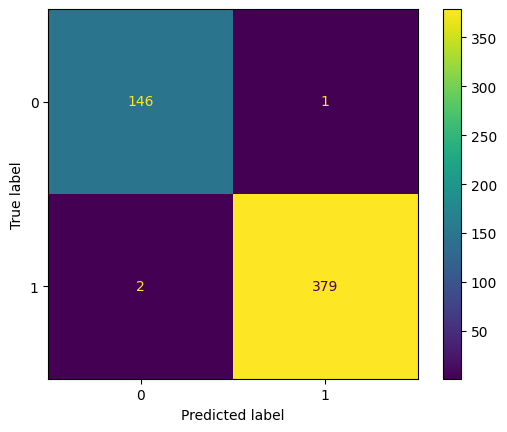

In [83]:
# Print the confusion matrix on the test data
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred2), display_labels=model['logistic'].classes_).plot()

In [84]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       1.00      0.99      1.00       381

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528



In [86]:
print(best_model.coef_)

# odds = exp(coef_)
odds = np.exp(best_model.coef_)

# Create a dataframe and sort by odds column with highest at top
pd.DataFrame(np.transpose(odds), X.columns, columns=['odds']).sort_values(by='odds', ascending=False)

[[ -1.21843293   0.30050269 -15.68327757  53.0817322   -0.06247856
    0.5527825   -0.43918648  -0.14449313  -0.90176484  -0.69401221
   -0.18199004   0.70780968  -0.71383753   0.52878175  -0.27639775
    0.10650886]]


,odds
Weight,1.130065e+23
SCC,2.029541e+00
FAVC,1.738083e+00
TUE,1.696864e+00
Age,1.350538e+00
MTRANS,1.112388e+00
family_history_with_overweight,9.394332e-01
NCP,8.654609e-01
CH2O,8.336096e-01
CALC,7.585112e-01


### Use the best_model to make a prediction.

In [87]:
# Create a dataset with data that matches the model's expected features
data_subject1 = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [121.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject1 = scaler.transform(data_subject1)

# Predict using the trained model
prediction = best_model.predict(data_subject1)

# Display the prediction
print(f"Prediction for subject 1: {prediction}")

Prediction for subject 1: [1]


# Discussion
Summarize what worked, what didn't etc.